In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from gensim.models import Word2Vec as wv

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import math
#import PhysicallyInformedLossFunction as PhysLoss



In [136]:
#Vocabulary from Carbon corpus and Word2Vec model trained on all abstracts
#Opening contents of Word2Vec model1

data = '/Users/alexchoe/Desktop/Capstone/m2py-master/data/all_abstracts_model/'
os.chdir(data)
model1 = wv.load('all_abstract_model.model')
vocabulary1 = list(model1.wv.vocab)


In [137]:
data = '/Users/alexchoe/Desktop/Capstone/BETO2020-master/data/carbon/'
os.chdir(data)
data_df = pd.read_excel('CombinedSynAntList.xlsx', index_col=0)

In [9]:
data_df

,word 1,word 2,relationship,label
0,infinite,bounded,ant,1
1,infinite,brief,ant,1
2,infinite,calculable,ant,NaN
3,infinite,ceasing,ant,1
4,infinite,ending,ant,1
...,...,...,...,...
1996,infinite,finite,ant,NaN
1997,infinite,intermittent,ant,NaN
1998,infinite,limited,ant,NaN
1999,infinite,little,ant,NaN


In [138]:
#data_df = data_df.rename(columns = {'Unnamed: 1':'word 1', 'Unnamed: 2':'word 2','Unnamed: 3':'relationship', 'Unnamed: 4': 'label'})

#Adding columns for the syn and ant score labeling as well as indices
#replacing all NaN values with 0
data_df['syn score'] = np.nan
data_df['ant score'] = np.nan
data_df['word 1 index'] = np.nan
data_df['word 2 index'] = np.nan
data_df = data_df.fillna(0)
data_df = data_df[1:]

#finding which words are in the pd but not in vocabulary1
list1 = list(data_df['word 1'])
list2 = list(data_df['word 2'])
missing = list((set(list1).difference(vocabulary1))) + list((set(list2).difference(vocabulary1)))

#keeping only the rows in the pd that have words in vocabulary1
data_df = data_df[~data_df['word 1'].isin(missing)]
data_df = data_df[~data_df['word 2'].isin(missing)]
data_df = data_df[~data_df['label'].str.contains('#', na=False)]

#reseting indeces after mask
data_df.reset_index(inplace = True)

#creating list of individual words that are both in vocabulary1 and excel sheet 
#dict.fromkeys() ensuring there are no duplicates
common = list(set(list1)&set(vocabulary1))+list(set(list2)&set(vocabulary1))
common = list(dict.fromkeys(common))
common = sorted(common)

data_df

,index,word 1,word 2,relationship,label,syn score,ant score,word 1 index,word 2 index
0,1,infinite,brief,ant,1,0.0,0.0,0.0,0.0
1,2,infinite,calculable,ant,0,0.0,0.0,0.0,0.0
2,3,infinite,ceasing,ant,1,0.0,0.0,0.0,0.0
3,4,infinite,ending,ant,1,0.0,0.0,0.0,0.0
4,5,infinite,ephemeral,ant,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
5307,1996,infinite,finite,ant,0,0.0,0.0,0.0,0.0
5308,1997,infinite,intermittent,ant,0,0.0,0.0,0.0,0.0
5309,1998,infinite,limited,ant,0,0.0,0.0,0.0,0.0
5310,1999,infinite,little,ant,0,0.0,0.0,0.0,0.0


In [139]:
#adding the index of the words as they are positioned in the list where "common" is the list or individual words
#creating data set with the w2v weights instead of strings
#adding syn scores and ant scores for good syns and ants
#anything not "good" has a score of 0

for i in range(len(data_df)): 
    
    data_df['word 1 index'].iloc[i] = common.index(data_df['word 1'].iloc[i])
    data_df['word 2 index'].iloc[i] = common.index(data_df['word 2'].iloc[i])
    
    data_df['word 1'].iloc[i] = model1.wv.__getitem__(str(data_df['word 1'].iloc[i])).tolist()
    data_df['word 2'].iloc[i] = model1.wv.__getitem__(str(data_df['word 2'].iloc[i])).tolist()
    
    if data_df['relationship'].iloc[i] == 'syn' and data_df['label'].iloc[i] == 1:
        data_df['syn score'].iloc[i] = 1
        data_df['ant score'].iloc[i] = -1
       
    elif data_df['relationship'].iloc[i] == 'ant' and data_df['label'].iloc[i] == 1:
        data_df['syn score'].iloc[i] = -1 
        data_df ['ant score'].iloc[i] = 1
        
    else:
        data_df['syn score'].iloc[i] = 0  
        data_df['ant score'].iloc[i] = 0
    

/Users/alexchoe/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [5]:
data_df.to_json('Phase_I_DATA.json')

In [6]:
data_df = pd.read_json('Phase_I_DATA.json', dtype = np.float32)

In [140]:
#splitting our data into train and test dataframes

X = data_df[['word 1 index', 'word 2 index']] #indices that will be used to find corresponding "feature" weights
Y = data_df[['syn score', 'ant score']] #what will ultimately be predicted

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, shuffle = True)

w1_train = x_train['word 1 index']
w1_test = x_test['word 1 index']
w2_train = x_train['word 2 index']
w2_test = x_test['word 2 index']
ss_train = y_train['syn score']
ss_test = y_test['syn score']
as_train = y_train['ant score']
as_test = y_test['ant score']

train_data = {'word 1 index': w1_train, 'word 2 index': w2_train, 'syn score': ss_train, 'ant score': as_train}
test_data = {'word 1 index': w1_test, 'word 2 index': w2_test, 'syn score': ss_test, 'ant score': as_test}
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)


In [141]:
train_df.to_json('Phase_I_Train.json')
test_df.to_json('Phase_I_Test.json')

In [142]:
#Hyper parameters
num_epochs = 100
batch_size = 50
learning_rate = 0.008

# Device configuration (GPU if available, otherwise CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [143]:
class Phase_I_Train_Dataset(Dataset):
    
    def __init__(self):
        
        data = pd.read_json('Phase_I_Train.json', dtype = np.float32)
        self.len = data.shape[0]
        
        data_x = list(zip(data['word 1 index'], data['word 2 index'])) #creating a list of tuples where [w1,w2] and [ss, as]
        data_y = list(zip(data['syn score'], data['ant score']))
            
        #split into x_data our features and y_data our targets
        self.x_data = torch.tensor(data_x)
        self.y_data = torch.tensor(data_y)
        
    def __len__(self):
        
        return self.len
    
    def __getitem__(self, index):
        
        return self.x_data[index], self.y_data[index]

if __name__ == '__main__':
    dataset = Phase_I_Train_Dataset()

In [144]:
class Phase_I_Test_Dataset(Dataset):
    
    def __init__(self):
        
        data = pd.read_json('Phase_I_Test.json', dtype = np.float32)
        self.len = data.shape[0]
        
        data_x = list(zip(data['word 1 index'], data['word 2 index'])) #creating a list of tuples where [w1,w2] and [ss, as]
        data_y = list(zip(data['syn score'], data['ant score']))
            
        #split into x_data our features and y_data our targets
        self.x_data = torch.tensor(data_x)
        self.y_data = torch.tensor(data_y)

      
    def __len__(self):
        
        return self.len
    
    def __getitem__(self, index):
        
        return self.x_data[index], self.y_data[index]

if __name__ == '__main__':
    dataset = Phase_I_Test_Dataset()

In [145]:
#DataLoader cell here
training_data_set = torch.utils.data.DataLoader(dataset = Phase_I_Train_Dataset(), batch_size = batch_size, shuffle = True)
testing_data_set = torch.utils.data.DataLoader(dataset = Phase_I_Test_Dataset(), batch_size = batch_size, shuffle = True)

In [146]:
class Embedding_Pre_Trained_Weights(nn.Module):
    """
    This class contains the pre-training of the Phase_I_NN neural network weights using a list of words from which
    a list of weights can be obtained. It is then converted that can then be embedded using the from_pretrained() 
    function into the NN model
    """
    def __init__(self, words, model):
        super(Embedding_Pre_Trained_Weights, self).__init__()
    
        for i in range(len(words)):
            words[i] = model.wv.__getitem__(words[i]).tolist()
    
        weight = torch.tensor(words)
    
        self.embedding = nn.Embedding.from_pretrained(weight)
    
    def forward(self, index):
        
        index_vector = self.embedding(torch.LongTensor(index))
        
        return index_vector
    

In [147]:
class Phase_I_NN(nn.Module):
    """
    This class contains the first of two neural networks to be used to determine synonymy, antonymy or irrelevance.
    Using w2v pre-trained embeddings that are then embedded into our NN using the nn.Embedding layer we are able to
    obtain the encoded embeddings of two words (pushed as a tuple) in synonym and antonym subspaces. These encodings
    are then used to calculate the synonymy and antonymy score of those two words.
    This mimics the Distiller method described by Asif Ali et al.
    """

    def __init__(self, in_dims, out_dims, common, model1):
        super(Phase_I_NN, self).__init__()
        
        #embedding layer
        self.embedded = Embedding_Pre_Trained_Weights(common, model1)
        
        #hidden layers
        self.hidden_layers = nn.Sequential(
        nn.Linear(50, 100), #expand
        nn.Softplus(),
        nn.Linear(100, 300),
        nn.Softplus()
        )
        
        self.S_branch = nn.Sequential( #synonym subspace branch
        nn.Dropout(0.1), #to limit overfitting
        nn.Linear(300,100), #compress
        nn.Softplus(),
        nn.Linear(100,50),
        nn.Softplus()
        )
        
        self.A_branch = nn.Sequential(#need some activation function after each Linear function. Softmax is the NLP convention.
        nn.Dropout(0.1), #to limit overfitting
        nn.Linear(300, 100), #compress
        nn.Softplus(),
        nn.Linear(100,50),
        nn.Softplus()
        )
        
        #other option is to define activation function here i.e. self.Softplus = torch.nn.Softplus() and use it in the forward pass
        
        
    def forward(self, index_tuple):
        
        em_1, em_2 = self.embedded(index_tuple)[0], self.embedded(index_tuple)[1]
        
        #pass through hidden layers. For each linear layer in the hidden/branches, use the activation function to push
        out_w1 = self.hidden_layers(em_1) 
        out_w2 = self.hidden_layers(em_2)
        
        #pass each embedded data through each branch to be situated in subspaces
        S1_out = self.S_branch(out_w1)
        S2_out = self.S_branch(out_w2)
        A1_out = self.A_branch(out_w1)
        A2_out = self.A_branch(out_w2)
        
        #Need to find a way to collect encoder embeddings as well as their scoring
        
        synonymy_score = F.cosine_similarity(S1_out.view(1,-1),S2_out.view(1,-1), dim=1) #do these outside of the NN class
        antonymy_score = torch.max(F.cosine_similarity(A1_out.view(1,-1),S2_out.view(1,-1),dim=1), F.cosine_similarity(A2_out.view(1,-1),S1_out.view(1,-1),dim=1))
        
        #print(antonymy_score.size())
        #return synonymy_score, antonymy_score #the encoders in each subspace
        
        return S1_out, S2_out, A1_out, A2_out, synonymy_score, antonymy_score

In [148]:
class Loss_Synonymy(nn.Module):
    """
    This class contains a loss function that uses the sum of ReLu loss to make predictions for the encoded embeddings
    in the synonym subspace. A lower and higher bound for synonymy are to be determined. Need to better understand the
    equation found in the Asif Ali et al. paper.
    """  
         #will need to include S score here
    def __init__ (self):
        super(Loss_Synonymy, self).__init__()
        
    def forward(self, S1_out, S2_out, synonymy_score):
 
        result_list = torch.zeros(S1_out.size(0))
        element_count = 0
        
        error_1 = torch.zeros(1,1)
        error_2 = torch.zeros(1,1)
            
        for x, a, b in zip(synonymy_score, S1_out, S2_out): #x=synscore, a=S1_out, b=S2_out
            
            #print(labels)
            
            if torch.ge(x, torch.tensor(0.8)) == True:
                error = F.relu(torch.add(torch.tensor(1), torch.neg(torch.tanh(torch.dist(a, b, 2))))) #assumed Euclidean Distance
                error_1 = torch.add(error_1,error)
                
            elif torch.lt(x, torch.tensor(0.8)) == True:
                error = F.relu(torch.add(torch.tensor(1), torch.tanh(torch.dist(a, b, 2))))
                error_2 = torch.add(error_2,error)
                
             
        #may need to collect error_1 and error_2 independently and add them batch by batch
        
        error_total = torch.add(error_1, error_2)
        
        result_list[element_count] = error_total
        element_count += 1
        
        result = result_list.mean()
        
        return result


In [149]:
class Loss_Antonymy(nn.Module):
    """
    This class contains a loss function that uses the sum of ReLu loss to make predictions for the encoded embeddings
    in the antonym subspace. A lower and higher bound for antonymy are to be determined. Need to better understand the
    equation found in the Asif Ali et al. paper.
    """
    
    def __init__(self):
        super(Loss_Antonymy, self).__init__()
       
    def forward(self, S2_out, A1_out, antonymy_score):
  
        result_list = torch.zeros(S2_out.size(0))
        element_count = 0
    
        error_1 = torch.zeros(1,1)
        error_2 = torch.zeros(1,1)
        
        for x, a, b in zip(antonymy_score, A1_out, S2_out): #x=antscore, a=A1_out, b=S2_out (to ensure trans-transitivity)
            
            if torch.ge(x, torch.tensor(0.8)) == True:
                error = F.relu(torch.add(torch.tensor(1), torch.neg(torch.tanh(torch.dist(a, b, 2)))))
                error_1 = torch.add(error_1,error)
                
            elif torch.lt(x, torch.tensor(0.8)) == True:
                error = F.relu(torch.add(torch.tensor(1), torch.tanh(torch.dist(a, b, 2))))
                error_2 = torch.add(error_2, error)
                 
        error_total = torch.add(error_1, error_2)
        
        error_total.retain_grad()
        result_list[element_count] = error_total
        element_count += 1
        
        result = result_list.mean()
        
        return result


In [150]:
class Loss_Labels(nn.Module):
    """
    This class is the last portion of the general loss function. Here the predicted synonymy and antonymy scores
    are concatenated and compared to the concatenated labeled synonymy and antonymy scores
    """
    def __init__(self):
        super(Loss_Labels, self).__init__()
       
    def forward(self, S1_out, synonymy_score, antonymy_score):
        
        result_list = torch.zeros(S1_out.size(0))
        element_count = 0
        
        for x, y in zip(synonymy_score, antonymy_score):
            
            #print(synonymy_score)
            #print(antonymy_score)
            #error_tensor = torch.tensor((x, y))
            error = torch.nn.functional.log_softmax(torch.stack((x,y),dim=0), dim=0)
            error = torch.argmax(error).float()
            #error.squeeze()
            
            error.requires_grad = True
            error.retain_grad()
            result_list[element_count] = error
            element_count += 1
            result = torch.neg(result_list.mean())
    
        return result

In [151]:
def Phase_I_train_model(model, training_data_set, optimizer):
    train_losses = []
    syn_train_losses = []
    ant_train_losses = []
    label_train_losses = []
    
    train_epoch_loss = []
    syn_train_epoch_loss = []
    ant_train_epoch_loss = []
    label_train_epoch_loss = []
    
    train_total = 0
    
    #switch model to training mode
    model.train()
    
    syn_criterion = Loss_Synonymy()
    ant_criterion = Loss_Antonymy()
    label_criterion = Loss_Labels()
    
    for i, data in enumerate(training_data_set,0):
        
        features, labels = data
        
        #have been encountering an issue where the data is not a double() but a float()
        features, labels = np.double(features), np.double(labels)
        
        model.zero_grad() #zero out any gradients from prior loops 
        S1_out, S2_out, A1_out, A2_out, synonymy_score, antonymy_score = model(features) #gather model predictions for this loop
        
        #calculate error in the predictions
        syn_loss = syn_criterion(S1_out, S2_out, synonymy_score)
        ant_loss = ant_criterion(S2_out, A1_out, antonymy_score)
        label_loss = label_criterion(S1_out, synonymy_score, antonymy_score)
        total_loss = syn_loss + ant_loss + label_loss #need to create a total_loss_criterion
        
        #BACKPROPAGATE LIKE A MF
        torch.autograd.backward([syn_loss, ant_loss, label_loss])
        optimizer.step()
        
        #save loss for this batch
        train_losses.append(total_loss.item())
        train_total+=1
        
        syn_train_losses.append(syn_loss.item())
        ant_train_losses.append(ant_loss.item())
        label_train_losses.append(label_loss.item())
        
    #calculate and save total error for this epoch of training
    epoch_loss = sum(train_losses)/train_total
    train_epoch_loss.append(epoch_loss)
    
    syn_train_epoch_loss.append(sum(syn_train_losses)/train_total)
    ant_train_epoch_loss.append(sum(ant_train_losses)/train_total)
    label_train_epoch_loss.append(sum(label_train_losses)/train_total)
    
    return train_epoch_loss, syn_train_epoch_loss, ant_train_epoch_loss, label_train_epoch_loss

In [152]:
def Phase_I_eval_model(model, testing_data_set, optimizer):
    #evaluate the model
    model.eval()
    
    syn_criterion = Loss_Synonymy() 
    ant_criterion = Loss_Antonymy()
    label_criterion = Loss_Labels()

    #don't update nodes during evaluation b/c not training
    with torch.no_grad():
        test_losses = []
        syn_test_losses = []
        ant_test_losses = []
        label_test_losses = []
        
        syn_test_acc_list = []
        ant_test_acc_list = []
        label_test_acc_list = []
        
        test_total = 0

        #for inputs, labels in testing_data_set:
        #similar change to the train_model portion due to the nature of our data
        #inputs = inputs.to(device)
        #labels = labels.to(device)
        
        for i, data in enumerate(testing_data_set,0):
        
            inputs, labels = data
        
            #have been encountering an issue where the data is not a double() but a float()
            inputs, labels = np.double(inputs), np.double(labels)
            
            S1_out, S2_out, A1_out, A2_out, synonymy_score, antonymy_score = model(inputs)

            # calculate loss per batch of testing data
            syn_test_loss = syn_criterion(S1_out, S2_out, synonymy_score)
            ant_test_loss = ant_criterion(S2_out, A1_out, antonymy_score)
            label_test_loss = label_criterion(S1_out, synonymy_score, antonymy_score)
            
            test_loss = syn_test_loss + ant_test_loss + label_test_loss 
            
            test_losses.append(test_loss.item())
            syn_test_losses.append(syn_test_loss.item())
            ant_test_losses.append(ant_test_loss.item())
            label_test_losses.append(label_test_loss.item())
            test_total += 1 
            
            #syn_test_acc_list.append(syn_acc.item())
            #ant_test_acc_list.append(ant_acc.item())
            #label_test_acc_list.append(label_acc.item())
            
            syn_el_count = 0
            syn_correct = 0
            for x, y in zip(synonymy_score, labels[0]):
                if x*0.8 <= y:
                    syn_correct += 1
                    syn_el_count += 1

                else:
                    syn_el_count += 1
            
            ant_el_count = 0
            ant_correct = 0
            for x, y in zip(antonymy_score, labels[1]):
                if x*0.8 <= y:
                    ant_correct += 1
                    ant_el_count += 1

                else:
                    ant_el_count += 1
            
        syn_acc = (syn_correct/syn_el_count) * 100
        syn_test_acc_list.append(syn_acc)
        
        ant_acc = (ant_correct/ant_el_count) * 100
        ant_test_acc_list.append(ant_acc)

        test_epoch_loss = sum(test_losses)/test_total
        syn_test_epoch_loss = sum(syn_test_losses)/test_total
        ant_test_epoch_loss = sum(ant_test_losses)/test_total
        label_test_epoch_loss = sum(label_test_losses)/test_total
        
        syn_epoch_acc = sum(syn_test_acc_list)/test_total
        ant_epoch_acc = sum(ant_test_acc_list)/test_total

        print(f"Total Epoch Testing Loss is: {test_epoch_loss}")
        print(f"Total Epoch Synonym Testing accuracy is: {syn_epoch_acc}")
        print(f"Total Epoch Antonym Testing accuracy is: {ant_epoch_acc}")

    return test_epoch_loss, syn_test_epoch_loss, ant_test_epoch_loss, label_test_epoch_loss, syn_epoch_acc, ant_epoch_acc


In [153]:
#%autoreload

def fit(model, lr, epochs):

    #define the optimizer
    optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)
    #empty list to hold loss per epoch
    train_epoch_losses = []
    syn_train_epoch_losses = []
    ant_train_epoch_losses = []
    label_train_epoch_losses = []

    test_epoch_losses = []
    syn_test_epoch_losses = []
    ant_test_epoch_losses = []
    label_test_epoch_losses = []


    syn_test_epoch_accuracies = []
    ant_test_epoch_accuracies = []
    test_epoch_accuracies = []

    #pce_test_epoch_r2 = []
    #voc_test_epoch_r2 = []
    #jsc_test_epoch_r2 = []
    #ff_test_epoch_r2 = []
    #test_epoch_r2s = []

    save_epochs = np.arange(0, num_epochs, 5)

    for epoch in range(num_epochs):
        print('On epoch ', epoch)
    
        #save_dir = "/Users/Thomas/Desktop/BETO2020-Remote/Ant_Syn_Scraping/"
        #model_name = "Phase_I_II_NN"
        #model_path = save_dir+model_name+'*.pt'
        #if epoch < 10:
            #save_path = save_dir + model_name + '_epoch0' + str(epoch) + '.pt'
        #else:
            #save_path = save_dir + model_name + '_epoch' + str(epoch) + '.pt'
        
#     if glob.glob(model_path) != []:
#         model_states = glob.glob(model_path)
#         model_states = sorted(model_states)
#         previous_model = model_states[-1]
        
#         model, optimizer = nuts.load_trained_model(previous_model, model, optimizer)
    
        train_epoch_loss, syn_train_epoch_loss, ant_train_epoch_loss, label_train_epoch_loss = Phase_I_train_model(model = model, training_data_set = training_data_set, optimizer = optimizer)
        train_epoch_losses.append(train_epoch_loss)
        syn_train_epoch_losses.append(syn_train_epoch_loss)
        ant_train_epoch_losses.append(ant_train_epoch_loss)
        label_train_epoch_losses.append(label_train_epoch_loss)


        test_epoch_loss, syn_test_epoch_loss, ant_test_epoch_loss, label_test_epoch_loss, syn_epoch_acc, ant_epoch_acc = Phase_I_eval_model(model = model, testing_data_set = testing_data_set, optimizer = optimizer)

        test_epoch_losses.append(test_epoch_loss)
        syn_test_epoch_losses.append(syn_test_epoch_loss)
        ant_test_epoch_losses.append(ant_test_epoch_loss)
        label_test_epoch_losses.append(label_test_epoch_loss)

        #tot_tst_loss = sum(test_epoch_loss, syn_test_epoch_loss, ant_test_epoch_loss, label_test_epoch_loss)
        #test_epoch_losses.append(tot_tst_loss)

        syn_test_epoch_accuracies.append(syn_epoch_acc)
        ant_test_epoch_accuracies.append(ant_epoch_acc)

        tot_test_acc = (syn_epoch_acc + ant_epoch_acc)
        test_epoch_accuracies.append(tot_test_acc)

        print('Finished epoch ', epoch)

    best_loss_indx = test_epoch_losses.index(min(test_epoch_losses))
    best_acc_indx = test_epoch_accuracies.index(min(test_epoch_accuracies))

    fit_results = {
        'lr': lr,
        'best_loss_epoch': best_loss_indx,
        'best_acc_epoch': best_acc_indx,
        #'best_r2_epoch': best_r2_indx,
        'syn_loss': syn_test_epoch_losses,
        'ant_loss': ant_test_epoch_losses,
        'label_loss': label_test_epoch_losses,
        'test_losses': test_epoch_losses,        
        'syn_acc': syn_test_epoch_accuracies,
        'ant_acc': ant_test_epoch_accuracies,
        'test_accs': test_epoch_accuracies,
        #'pce_r2': pce_test_epoch_r2,
        #'voc_r2': voc_test_epoch_r2,
        #'jsc_r2': jsc_test_epoch_r2,
        #'ff_r2': ff_test_epoch_r2,
        #'test_r2s': test_epoch_r2s,
        'train_syn_loss': syn_train_epoch_losses,
        'train_ant_loss': ant_train_epoch_losses,
        'train_label_loss': label_train_epoch_losses,
    }

    return fit_results

In [154]:
#Network Utilities

def init_weights(model):
    
    classname = model.__class__.__name__
    
    if classname.find('Linear') != -1:
        torch.nn.init.xavier_uniform_(model.weight)
        torch.nn.init.zeros_(model.bias)
        
    elif classname.find('Conv2d') != -1:
        torch.nn.init.xavier_uniform_(model.weight)
        torch.nn.init.zeros_(model.bias)
        
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.xavier_uniform_(model.weight)
        torch.nn.init.zeros_(model.bias)

In [155]:
#in_dims = int(torch.tensor(x_train).size(1)) #number of x channels
#out_dims = y_test.shape[1] #number of predicted features

model = Phase_I_NN(in_dims = 50, out_dims = 2, common = common, model1 = model1).to(device)
model.apply(init_weights)

Phase_I_NN(
  (embedded): Embedding_Pre_Trained_Weights(
    (embedding): Embedding(2990, 50)
  )
  (hidden_layers): Sequential(
    (0): Linear(in_features=50, out_features=100, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=100, out_features=300, bias=True)
    (3): Softplus(beta=1, threshold=20)
  )
  (S_branch): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=300, out_features=100, bias=True)
    (2): Softplus(beta=1, threshold=20)
    (3): Linear(in_features=100, out_features=50, bias=True)
    (4): Softplus(beta=1, threshold=20)
  )
  (A_branch): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=300, out_features=100, bias=True)
    (2): Softplus(beta=1, threshold=20)
    (3): Linear(in_features=100, out_features=50, bias=True)
    (4): Softplus(beta=1, threshold=20)
  )
)

In [156]:
#%autoreload

lrs = np.linspace(3e-3, 1e-2, 50)

lr_opt = {}

for i, lr in enumerate(lrs):
    print(f'  optimization loop {i}')
    print('-----------------------------')
    
    lr_opt[i] = fit(model, lr, epochs = 30)

  optimization loop 0
-----------------------------
On epoch  0
Total Epoch Testing Loss is: 1.3636363636363635
Total Epoch Synonym Testing accuracy is: 0.0
Total Epoch Antonym Testing accuracy is: 4.545454545454546
Finished epoch  0
On epoch  1
Total Epoch Testing Loss is: 1.2727272727272727
Total Epoch Synonym Testing accuracy is: 0.0
Total Epoch Antonym Testing accuracy is: 0.0
Finished epoch  1
On epoch  2
Total Epoch Testing Loss is: 1.4090909090909092
Total Epoch Synonym Testing accuracy is: 0.0
Total Epoch Antonym Testing accuracy is: 0.0
Finished epoch  2
On epoch  3
Total Epoch Testing Loss is: 1.2272727272727273
Total Epoch Synonym Testing accuracy is: 0.0
Total Epoch Antonym Testing accuracy is: 0.0
Finished epoch  3
On epoch  4
Total Epoch Testing Loss is: 1.4090909090909092
Total Epoch Synonym Testing accuracy is: 0.0
Total Epoch Antonym Testing accuracy is: 4.545454545454546
Finished epoch  4
On epoch  5
Total Epoch Testing Loss is: 1.0681818181818181
Total Epoch Synonym 

In [157]:
lr_opt

{0: {'lr': 0.003,
  'best_loss_epoch': 5,
  'best_acc_epoch': 1,
  'syn_loss': [0.5,
   0.36363636363636365,
   0.5454545454545454,
   0.36363636363636365,
   0.5909090881997888,
   0.13636363636363635,
   0.2727272727272727,
   0.4318181818181818,
   0.4090909090909091,
   0.5,
   0.45454545454545453,
   0.2727272727272727,
   0.4090909090909091,
   0.2727272727272727,
   0.5,
   0.5,
   0.3181818181818182,
   0.38636363636363635,
   0.36363636363636365,
   0.4090909090909091,
   0.5909090909090909,
   0.4318181818181818,
   0.45454545454545453,
   0.36363636363636365,
   0.4090909090909091,
   0.2727272727272727,
   0.5,
   0.4090909090909091,
   0.31818208640271967,
   0.2727272727272727,
   0.4090909090909091,
   0.22727272727272727,
   0.2727272727272727,
   0.36363636363636365,
   0.36363636363636365,
   0.3181818181818182,
   0.3181818181818182,
   0.5454545454545454,
   0.5000000406395305,
   0.22727272727272727,
   0.45454545454545453,
   0.36363636363636365,
   0.590909090909

In [ ]:
with open('./json/20200715_OPVNN2_hpo_results_r2.json', 'w') as fp:
    json.dump(lr_opt, fp)

In [ ]:
with open('./json/20200715_OPVNN2_hpo_results_r2.json') as json_file:
    data = json.load(json_file)

data['0'].keys()

In [ ]:
def plot_fit_results(fit_dict):
    lr = float(fit_dict['lr'])
    best_loss_epoch = int(fit_dict['best_loss_epoch'])
    best_acc_epoch = int(fit_dict['best_acc_epoch'])
    #best_r2_epoch = int(fit_dict['best_r2_epoch'])
    
    test_loss = [float(i) for i in fit_dict['test_losses']]
    syn_loss = [float(i) for i in fit_dict['syn_loss']]
    ant_loss = [float(i) for i in fit_dict['ant_loss']]
    label_loss = [float(i) for i in fit_dict['label_loss']]
    
    test_acc = [float(i) for i in fit_dict['test_accs']]
    syn_acc = [float(i) for i in fit_dict['syn_acc']]
    ant_acc = [float(i) for i in fit_dict['ant_acc']]
    
    #test_r2 = [float(i) for i in fit_dict['test_r2s']]
    #pce_r2 = [float(i) for i in fit_dict['pce_r2']]
    #voc_r2 = [float(i) for i in fit_dict['voc_r2']]
    #jsc_r2 = [float(i) for i in fit_dict['jsc_r2']]
    #ff_r2 = [float(i) for i in fit_dict['ff_r2']]
    
    train_syn_loss = [float(i) for i in fit_dict['train_syn_loss']]
    train_ant_loss = [float(i) for i in fit_dict['train_ant_loss']]
    train_label_loss = [float(i) for i in fit_dict['train_label_loss']]

    epochs = np.arange(0, (len(test_loss)), 1)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 6))
    ax1.plot(epochs, pce_loss, c = 'r', label = 'syn loss')
    ax1.plot(epochs, voc_loss, c = 'g', label = 'ant loss')
    ax1.plot(epochs, jsc_loss, c = 'b', label = 'label loss')
    ax1.plot(epochs, test_loss, c = 'c', label = 'total loss')
    ax1.plot(epochs, train_pce_loss, c = 'r', linestyle = '-.', label = 'syn train loss')
    ax1.plot(epochs, train_voc_loss, c = 'g', linestyle = '-.', label = 'ant train loss')
    ax1.plot(epochs, train_jsc_loss, c = 'b', linestyle = '-.', label = 'label train loss')
    ax1.scatter(best_loss_epoch, min(test_loss), alpha = 0.8, s = 64, c = 'turquoise')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Custom Error Loss')
    ax1.legend(loc = 'best')
    ax1.set_title(f'Custom Loss with lr = {lr}')

    ax2.plot(epochs, pce_acc, c = 'r', label = 'syn acc')
    ax2.plot(epochs, voc_acc, c = 'g', label = 'ant acc')
    ax2.plot(epochs, test_acc, c = 'b', label = 'total acc')
    ax2.scatter(best_acc_epoch, min(test_acc), alpha = 0.8, s = 64, c = 'turquoise')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Mean Absolute Percent Accuracy')
    ax2.legend(loc = 'best')
    ax2.set_title(f'Accuracies with lr = {lr}')

    #ax3.plot(epochs, pce_r2, c = 'r', label = 'pce R$^2$')
    #ax3.plot(epochs, voc_r2, c = 'g', label = 'voc R$^2$')
    #ax3.plot(epochs, jsc_r2, c = 'b', label = 'jsc R$^2$')
    #ax3.plot(epochs, ff_r2, c = 'c', label = 'ff R$^2$')
    #ax3.plot(epochs, test_r2, c = 'k', label = 'total R$^2$')
    #ax3.scatter(best_r2_epoch, max(test_r2), alpha = 0.8, s = 64, c = 'turquoise')
    #ax3.set_xlabel('Epochs')
    #ax3.set_ylabel('R$^2$')
    #ax3.legend(loc = 'best')
    #ax3.set_title(f'R$^2$ with lr = {lr}')
    
    plt.tight_layout()
    plt.show()

In [19]:
# Instantiate our beautiful NN model
# takes in 
# predicts synonymy
model = Phase_I_NN(in_dims = 50, out_dims = 2, common = common, model1 = model1).to(device)

#define the optimizer
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)


In [ ]:
for key, fit_dict in data.items():
    plot_fit_results(fit_dict)

In [ ]:
# To complete after plots are confirmed to work
def best_fit_lrs(fit_dict):
    """
    Function that sorts through hyperparameter optimization results dictionaries and collects
    the 5 best learning rates and epochs.
    """
    best_params = {}
    
    #initialize variables with poor values
    lowest_loss = 200
    lowest_acc = 200
    #highest_r2 = -200
    
    #for each lr fit, collect best values
    best_losses = []
    best_accs = []
    best_r2s = []
    
    for key, fit in fit_dict.items():
        
        loss_ep = fit['best_loss_epoch']
#         acc_ep = fit['best_acc_epoch']
#         r2_ep = fit['best_r2_epoch']
        
        #these all need to come from the same epoch for parameter selection
        best_losses.append(fit['test_losses'][loss_ep])
        best_accs.append(fit['test_accs'][loss_ep])
        #best_r2s.append(fit['test_r2s'][loss_ep])
        
    return

def plot_best_fit_lrs(fit_dict):
    """
    A function that plots the best loss, accuracy, and r2 of a lr fit series. Note
    that the epoch shown is loss's best epoch, which many not correspond to the best
    epoch for accuracy or r2.
    """
    
    #for each lr fit, collect best values
    lrs = []
    best_losses = []
    best_accs = []
    best_r2s = []
    
    for key, fit in fit_dict.items():
        lrs.append(fit['lr'])
        
        loss_ep = fit['best_loss_epoch']
        acc_ep = fit['best_acc_epoch']
        r2_ep = fit['best_r2_epoch']
        
        #these will all need to come from the same epoch during parameter selection
        best_losses.append(fit['test_losses'][loss_ep])
        best_accs.append(fit['test_accs'][acc_ep])
        best_r2s.append(fit['test_r2s'][r2_ep])
        
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 6))
    ax1.plot(lrs, best_losses, c = 'r')
    ax1.scatter(lrs[best_losses.index(min(best_losses))], min(best_losses), s = 64, alpha = 0.8, c = 'turquoise')
    ax1.set_xlabel('Learning Rates')
    ax1.set_ylabel('Mean Squared Error Loss')
    ax1.set_title(f'MSE Loss with lr')
    
    ax2.plot(lrs, best_accs, c = 'r')
    ax2.scatter(lrs[best_accs.index(min(best_accs))], min(best_accs), s = 64, alpha = 0.8, c = 'turquoise')
    ax2.set_xlabel('Learning Rates')
    ax2.set_ylabel('Mean Absolute Percent Error')
    ax2.set_title(f'MAPE with lr')
    
    ax3.plot(lrs, best_r2s, c = 'r')
    ax3.scatter(lrs[best_r2s.index(max(best_r2s))], max(best_r2s), s = 64, alpha = 0.8, c = 'turquoise')
    ax3.set_xlabel('Learning Rates')
    ax3.set_ylabel('R$^2$')
    ax3.set_title(f'R$^2$ with lr')
    
    plt.tight_layout()
    plt.show()

In [ ]:
plot_best_fit_lrs(data)

In [20]:
#empty list to hold loss per epoch
train_epoch_losses = []
syn_train_epoch_losses = []
ant_train_epoch_losses = []
label_train_epoch_losses = []

test_epoch_losses = []
syn_test_epoch_losses = []
ant_test_epoch_losses = []
label_test_epoch_losses = []

syn_test_epoch_accuracies = []
ant_test_epoch_accuracies = []

for epoch in range(num_epochs):
    
    train_epoch_loss, syn_train_epoch_loss, ant_train_epoch_loss, label_train_epoch_loss  = Phase_I_train_model(model = model, training_data_set = training_data_set, optimizer = optimizer)
    
    train_epoch_losses.append(train_epoch_loss)
    syn_train_epoch_losses.append(syn_train_epoch_loss)
    ant_train_epoch_losses.append(ant_train_epoch_loss)
    label_train_epoch_losses.append(label_train_epoch_loss)
   
    test_epoch_loss, syn_test_epoch_loss, ant_test_epoch_loss, label_test_epoch_loss, syn_epoch_acc, ant_epoch_acc = Phase_I_eval_model(model = model, testing_data_set = testing_data_set, optimizer = optimizer)
    test_epoch_losses.append(test_epoch_loss)
    syn_test_epoch_losses.append(syn_test_epoch_loss)
    ant_test_epoch_losses.append(ant_test_epoch_loss)
    label_test_epoch_losses.append(label_test_epoch_loss)
    
    syn_test_epoch_accuracies.append(syn_epoch_acc)
    ant_test_epoch_accuracies.append(ant_epoch_acc)
    #test_epoch_losses.append(test_epoch_loss)
    #syn_test_epoch_losses.append(syn_test_epoch_loss)


Total Epoch Testing Loss is: 1.4090909090909092
Total Epoch Synonym Testing accuracy is: 0.0
Total Epoch Antonym Testing accuracy is: 4.545454545454546
Total Epoch Testing Loss is: 1.6363636363636365
Total Epoch Synonym Testing accuracy is: 0.0
Total Epoch Antonym Testing accuracy is: 0.0
Total Epoch Testing Loss is: 1.5454545454545454
Total Epoch Synonym Testing accuracy is: 0.0
Total Epoch Antonym Testing accuracy is: 0.0
Total Epoch Testing Loss is: 1.6363636363636365
Total Epoch Synonym Testing accuracy is: 0.0
Total Epoch Antonym Testing accuracy is: 0.0
Total Epoch Testing Loss is: 1.4266084107485684
Total Epoch Synonym Testing accuracy is: 0.0
Total Epoch Antonym Testing accuracy is: 4.545454545454546
Total Epoch Testing Loss is: 1.6818181818181819
Total Epoch Synonym Testing accuracy is: 0.0
Total Epoch Antonym Testing accuracy is: 0.0
Total Epoch Testing Loss is: 1.6136363636363635
Total Epoch Synonym Testing accuracy is: 4.545454545454546
Total Epoch Antonym Testing accuracy 

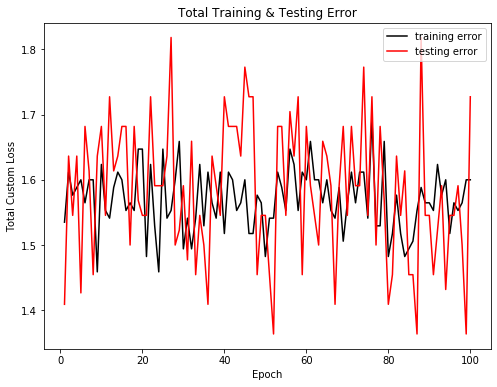

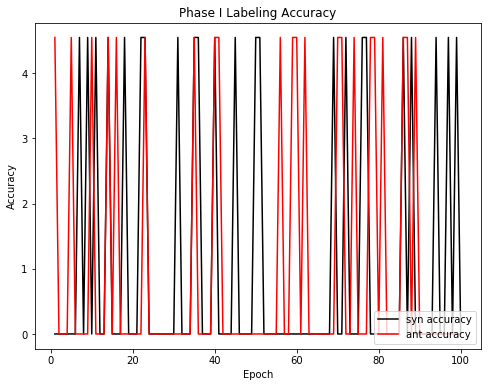

In [21]:
fig, ax = plt.subplots(figsize = (8,6))

epochs = np.arange(1, (num_epochs+1), 1)

plt.plot(epochs, train_epoch_losses, c = 'k', label = 'training error')
plt.plot(epochs, test_epoch_losses, c = 'r', label = 'testing error')
plt.legend(loc = 'upper right')
plt.title("Total Training & Testing Error")
ax.set_xlabel('Epoch')
ax.set_ylabel('Total Custom Loss')
plt.show()

fig, ax = plt.subplots(figsize = (8,6))
plt.plot(epochs, syn_test_epoch_accuracies, c = 'k', label = 'syn accuracy')
plt.plot(epochs, ant_test_epoch_accuracies, c = 'r', label = 'ant accuracy')
#plt.plot(epochs, voc_test_epoch_accuracies, c = 'r', label = 'voc accuracy')
#plt.plot(epochs, jsc_test_epoch_accuracies, c = 'g', label = 'jsc accuracy')
#plt.plot(epochs, ff_test_epoch_accuracies, c = 'b', label = 'ff accuracy')
plt.legend(loc = 'lower right')
plt.title("Phase I Labeling Accuracy")
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
plt.show()

In [ ]:
def Phase_II_train_model(model, training_data_set, optimizer):
    train_losses = []
    syn_train_losses = []
    ant_trian_losses
    
    train_epoch_loss = []
    syn_train_epoch_loss = []
    ant_train_epoch_loss
    
    train_total = 0
    
    #switch model to training mode
    model.train()
    
    syn_criterion = nn.MSELoss()
    ant_criterion = 
    
    #for features, labels in training_data_set: 
    
    #may need to change above "features" portion here to accomodate for our custom dataset
    #below is proposed alternative
    
    for i, data in enumerate(training_data_set,0):
        
        features, labels = data
        
        #have been encountering an issue where the data is not a double() but a float()
        features, labels = np.double(features), np.double(labels)
        
        model.zero_grad() #zero out any gradients from prior loops 
        syn_out = model(features) #gather model predictions for this loop
        
        #calculate error in the predictions
        syn_loss = syn_criterion(syn_out, labels)
        total_loss = syn_loss
        
        #BACKPROPAGATE LIKE A MF
        torch.autograd.backward([syn_loss])
        optimizer.step()
        
        #save loss for this batch
        train_losses.append(total_loss.item())
        train_total+=1
        
        syn_train_losses.append(syn_loss.item())
        
    #calculate and save total error for this epoch of training
    epoch_loss = sum(train_losses)/train_total
    train_epoch_loss.append(epoch_loss)
    
    syn_train_epoch_loss.append(sum(syn_train_losses)/train_total)
    
    #update progress bar
    print(f"Total Epoch Training Loss is: {train_epoch_loss}")
    
    return train_epoch_loss, syn_train_epoch_loss

In [ ]:
def Phase_II_eval_model(model, testing_data_set, optimizer):
    #evaluate the model
    model.eval()
    
    syn_criterion = nn.MSELoss()
    #accuracy = #total number of correct predictions divided by the total number of predictions

    #don't update nodes during evaluation b/c not training
    with torch.no_grad():
        test_losses = []
        syn_test_losses = []
        #syn_test_acc_list = []
        
        test_total = 0

        #for inputs, labels in testing_data_set:
        #similar change to the train_model portion due to the nature of our data
        #inputs = inputs.to(device)
        #labels = labels.to(device)
        
        for i, data in enumerate(testing_data_set,0):
        
            inputs, labels = data
        
            #have been encountering an issue where the data is not a double() but a float()
            inputs, labels = np.double(inputs), np.double(labels)
            
            syn_out = model(inputs)

            # calculate loss per batch of testing data
            syn_test_loss = syn_criterion(syn_out, labels)
            
            test_loss = syn_test_loss
            
            test_losses.append(test_loss.item())
            syn_test_losses.append(syn_test_loss.item())
            test_total += 1 
            #syn_acc = accuracy(syn_out)
            #syn_test_acc_list.append(syn_acc.item())

        test_epoch_loss = sum(test_losses)/test_total
        syn_test_epoch_loss = sum(syn_test_losses)/test_total
        
        #syn_epoch_acc = sum(syn_test_acc_list)/test_total

        print(f"Total Epoch Testing Loss is: {test_epoch_loss}")
        #print(f"Epoch MAPE: Syn = {syn_epoch_acc}")
    
    return test_epoch_loss, syn_test_epoch_loss, #syn_epoch_acc


In [ ]:
# Instantiate our beautiful NN model
# takes in 
# predicts synonymy
model = SYN_TEST(in_dims = 50, out_dims = 2).to(device)

#define the optimizer
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)



In [ ]:
#empty list to hold loss per epoch
train_epoch_losses = []
syn_train_epoch_losses = []

test_epoch_losses = []
syn_test_epoch_losses = []

syn_test_epoch_accuracies = []


for epoch in range(num_epochs):
    
    train_epoch_loss, syn_train_epoch_loss  = train_model(model = model, training_data_set = training_data_set, optimizer = optimizer)
    
    train_epoch_losses.append(train_epoch_loss)
    syn_train_epoch_losses.append(syn_train_epoch_loss)
   
    test_epoch_loss, syn_test_epoch_loss = eval_model(model = model, testing_data_set = testing_data_set, optimizer = optimizer)
    #syn_epoch_acc
    
    test_epoch_losses.append(test_epoch_loss)
    syn_test_epoch_losses.append(syn_test_epoch_loss)
    
    #pce_test_epoch_accuracies.append(pce_epoch_acc)
    #voc_test_epoch_accuracies.append(voc_epoch_acc)
    #jsc_test_epoch_accuracies.append(jsc_epoch_acc)
    #ff_test_epoch_accuracies.append(ff_epoch_acc)